In [96]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils.io import preprocess_data
import matplotlib.gridspec as gridspec
import numpy as np
from paths import TRAINING_DATA_PATH,EXAMPLE_PATH
import glob
import simpa as sp
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import umap
from matplotlib.colors import LinearSegmentedColormap

COLOURS = ["#201923", "#fcff5d", "#7dfc00", "#0ec434", "#228c68",
           "#8ad8e8", "#235b54", "#29bdab", "#3998f5", "#37294f", "#277da7",
           "#3750db", "#f22020", "#991919", "#ffcba5", "#e68f66", "#c56133",
           "#96341c", "#632819", "#ffc413", "#f47a22", "#2f2aa0", "#b732cc",
           "#772b9d", "#f07cab", "#d30b94", "#edeff3", "#c3a5b4", "#946aa2", "#5d4c86"]

PATHS = glob.glob(TRAINING_DATA_PATH + "/*")
PATHS = [PATHS[0]] + PATHS[2:]
np.random.seed(1337)
rnd_state = np.random.RandomState(1337)

NUM_RANDOM_DATAPOINTS = 200000

In [57]:
images = [
    "Baseline_10000.hdf5",
    "Illum_pencil_10000.hdf5",
    "SmallVessels_10000.hdf5",
    "Water_4cm_10000.hdf5"
]

example_images = []

for image in images:
    example_images.append(sp.load_data_field(EXAMPLE_PATH + image,
                            sp.Tags.DATA_FIELD_INITIAL_PRESSURE,
                            800))

In [21]:
print("Loading data...")
all_data = []
all_oxy = []
all_ds_idx = []
datasets = []

for ds_idx, path in enumerate(PATHS):
    base_filename = path.split("/")[-1].split("\\")[-1]
    if base_filename == "ALL":
        continue
    datasets.append(base_filename)
    spectra, oxy = preprocess_data(f"{path}/{base_filename}_train.npz", 41)
    all_data.append(spectra)
    all_oxy.append(oxy)
    all_ds_idx.append(np.ones_like(oxy) * ds_idx)

all_data = np.hstack(all_data)
all_oxy = np.hstack(all_oxy)
all_ds_idx = np.hstack(all_ds_idx)
print("Loading data...[Done]")

Loading data...
Loading data...[Done]


In [7]:
random_idx = np.random.choice(len(all_data.T), NUM_RANDOM_DATAPOINTS, replace=False)
n_datasets = len(np.unique(all_ds_idx))
reducer = umap.UMAP(random_state=rnd_state, verbose=True)
print("Embedding data...")
embedding = reducer.fit_transform(all_data[:, random_idx].T)
print("Embedding data...[Done]")

Embedding data...
UMAP(random_state=RandomState(MT19937) at 0x20700151740, verbose=True)
Wed Aug 23 11:14:16 2023 Construct fuzzy simplicial set
Wed Aug 23 11:14:16 2023 Finding Nearest Neighbors
Wed Aug 23 11:14:16 2023 Building RP forest with 27 trees
Wed Aug 23 11:14:16 2023 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	 4  /  18
	 5  /  18
	 6  /  18
	Stopping threshold met -- exiting after 6 iterations
Wed Aug 23 11:14:22 2023 Finished Nearest Neighbor Search
Wed Aug 23 11:14:23 2023 Construct embedding



Wed Aug 23 11:17:01 2023 Finished embedding
Embedding data...[Done]


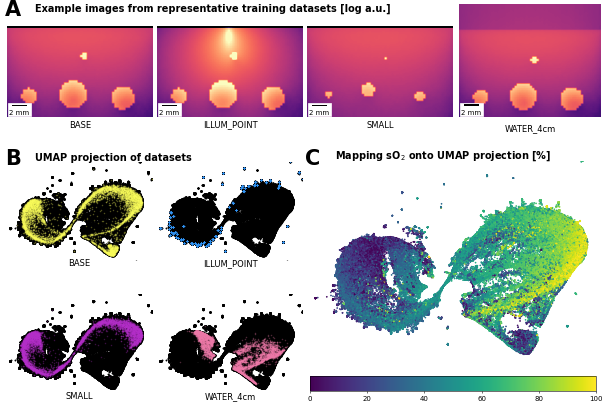

In [101]:
fig = plt.figure(figsize=(12, 8), layout="constrained", dpi=500)
# plt.suptitle('UMAP projection of all datasets with semantic encoding', fontsize=14, fontweight="bold")

GridSpec = gridspec.GridSpec(ncols=12, nrows=3, figure= fig)

# colors = [COLOURS[int(i)] for i in all_ds_idx[random_idx]]
cmap = LinearSegmentedColormap.from_list("test", COLOURS[:25], N=n_datasets)

subfigure_2= fig.add_subfigure(GridSpec[1:,6:12])
subfigure_2.text(0, 0.90, "C", size=30, weight='bold')
subplots_2 = subfigure_2.subplots(1, 1)
dat_2 = subplots_2.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=all_oxy[random_idx] * 100,
    s=2,
    alpha=1,
    vmin=0, vmax=100)
cbar2 = plt.colorbar(dat_2, orientation="horizontal")
subfigure_2.text(0.1, 0.92, "Mapping sO$_2$ onto UMAP projection [%]", size=14, weight='bold')
#cbar2.set_label("Oxygenation [%]", fontweight="bold", fontsize=12)
subplots_2.set_ylim(-9, 10)
subplots_2.set_xlim(-10, 17)
subplots_2.axis("off")
subplots_2.set_aspect('equal')


subfigure_1= fig.add_subfigure(GridSpec[1:,0:6])
((ax0, ax1), (ax2, ax3)) = subfigure_1.subplots(2, 2)
subfigure_1.text(0.1, 0.915, "UMAP projection of datasets", fontweight="bold", fontsize=14)
subfigure_1.text(0, 0.90, "B", size=30, weight='bold')

def plot_for_index(axis, index):

    axis.axis("off")
    axis.set_title(datasets[index], y=-0.1)
    axis.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c="black",
        alpha=1,
        s=3)
    axis.scatter(
        embedding[all_ds_idx[random_idx]==index, 0],
        embedding[all_ds_idx[random_idx]==index, 1],
        c=COLOURS[index],
        alpha=0.2,
        s=2)
    axis.set_aspect('equal')
    axis.set_ylim(-9, 10)
    axis.set_xlim(-10, 18)
    axis.set_anchor('S')
    
indexes = [1, 8, 22, 24]

plot_for_index(ax0, 1)
plot_for_index(ax1, 8)
plot_for_index(ax2, 22)
plot_for_index(ax3, 24)

subfigure_3 = fig.add_subfigure(GridSpec[0,0:12])
subfigure_3.text(0, 0.90, "A", size=30, weight='bold')
subfigure_3.text(0.05, 0.93, "Example images from representative training datasets [log a.u.]", size=14, weight='bold')
axes_3 = subfigure_3.subplots(1, 4)

for ax, img, idx in zip(axes_3, example_images, indexes):
    ax.imshow(np.log(img[:, int(len(img)/2), -75:-24].T), cmap="magma", vmin=0, vmax=10)
    scalebar = ScaleBar(0.3, "mm", location="lower left")
    ax.add_artist(scalebar)
    ax.axis("off")
    ax.set_title(datasets[idx], y=-0.15)
    ax.set_anchor('S')

plt.savefig("figure2.png")
plt.close()